# Data

## Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:

# ► For prophet model (Time series)

import fbprophet
import matplotlib.pyplot as plt

In [4]:
# ► For PyCaret model (Regression models)

!pip install pycaret==2.0


In [5]:
# ► For arima model (Time series)

!pip install pmdarima
from pmdarima.arima import auto_arima
from scipy import stats
from itertools import product
import warnings
import statsmodels.api as sm

In [6]:
# ► Libraries for xgboost

import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [7]:
# ► libraries for LSTM and GRU RNN's

# ► To flat a list of lists
from pandas.core.common import flatten
# ► Scale Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler                
# ► Indicator
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
# ► Model Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD

## Exploring data

In [8]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv', header=1)
kill_am = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %I-%p')
data['Date'] = data['Date'].apply(kill_am)
data.head()

Unix Timestamp                Date  ... Volume BTC  Volume USDT
0    1.601363e+09 2020-09-29 07:00:00  ...     185.20   1987813.05
1    1.601359e+09 2020-09-29 06:00:00  ...    1762.27  18868995.88
2    1.601356e+09 2020-09-29 05:00:00  ...    1169.17  12494919.04
3    1.601352e+09 2020-09-29 04:00:00  ...     993.53  10631885.02
4    1.601348e+09 2020-09-29 03:00:00  ...    1101.55  11782521.16

[5 rows x 9 columns]

In [9]:

data.tail()

Unix Timestamp                Date  ... Volume BTC  Volume USDT
27335    1.502957e+09 2017-08-17 08:00:00  ...     0.9499      4139.70
27336    1.502953e+09 2017-08-17 07:00:00  ...     4.4400     19241.06
27337    1.502950e+09 2017-08-17 06:00:00  ...     7.2300     31282.31
27338    1.502946e+09 2017-08-17 05:00:00  ...    23.2300    100304.82
27339    1.502942e+09 2017-08-17 04:00:00  ...    44.5100    190952.85

[5 rows x 9 columns]

In [10]:
data.dtypes

Unix Timestamp           float64
Date              datetime64[ns]
Symbol                    object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Volume BTC               float64
Volume USDT              float64
dtype: object

In [11]:
len(data)

27340

In [12]:
my_coin = data.copy()

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Open'],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['High'],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Low'],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Close'],
                    mode='lines',
                    name='Close'))

#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="BTC by hours, price in USDT")

# Models

3 days = 72 hours of real data to compare with forecastings

In [14]:
my_coin = data[['High','Date']].copy()[::-1]

In [15]:
# ► Data for training till last 72 hours

my_coin_high_train = my_coin[['High','Date']][:-72]

In [16]:

# ► Data for testing 72 hours

my_coin_high_test = my_coin[['High','Date']][-72:]

## FbProphet

In [17]:
# ► Renaming columns for Prophet syntax

my_coin_high_p = my_coin_high_train.rename(columns = {'Date':'ds','High':'y'})

In [18]:
m = fbprophet.Prophet(changepoint_prior_scale=1.1)

In [19]:
m.fit(my_coin_high_p)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [20]:
# ► Generating future 20 dates

future = m.make_future_dataframe(freq='H',periods=72)

In [21]:
len(future)

27340

In [22]:
# ► Predicting those days

forecast_p = m.predict(future)

In [23]:
len(forecast_p)

27340

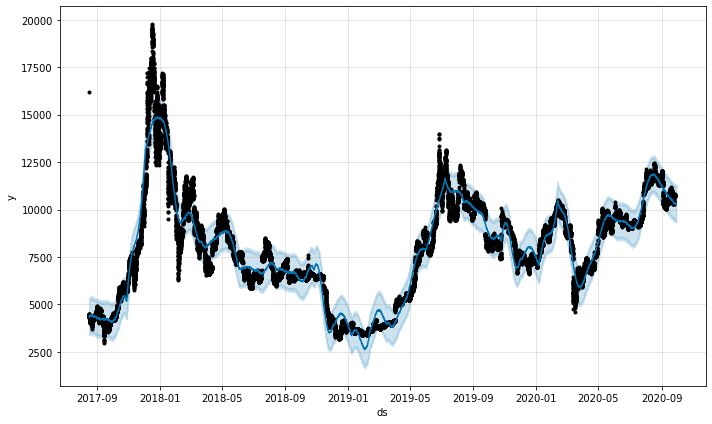

In [24]:
m.plot(forecast_p);

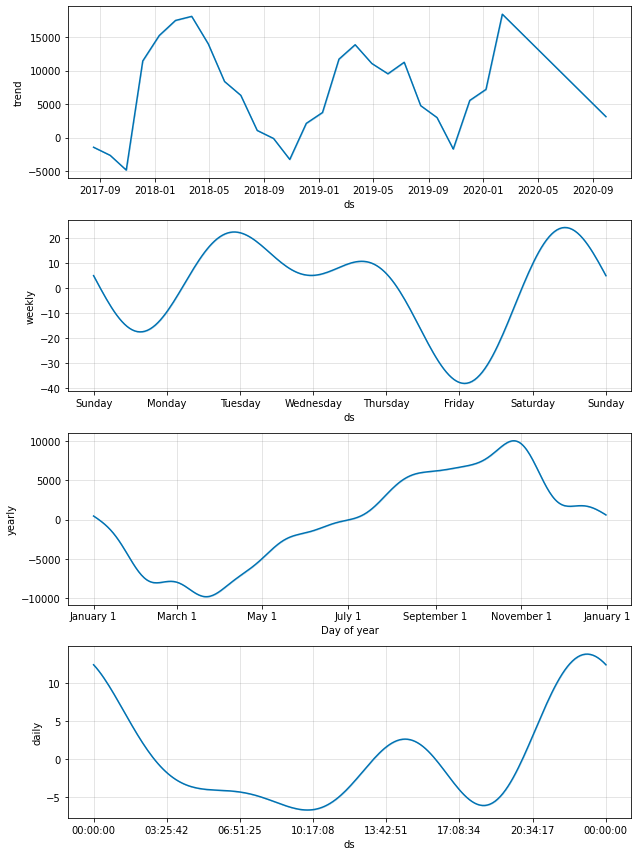

In [25]:
m.plot_components(forecast_p);

In [26]:
# ► predictions and real price

my_coin_inverse = my_coin.copy() 
my_coin_inverse.High = my_coin_inverse.High.values[::-1]                        # To change value orders from the original data
my_coin_forecast = pd.concat([forecast_p['ds'],my_coin_inverse['High'],forecast_p['yhat']], axis=1,keys=['date','high','prophet_high'])

In [27]:
# ► The model didn't see this high values

my_coin_forecast.tail()

date      high  prophet_high
27335 2020-09-29 03:00:00  10710.00  10311.481945
27336 2020-09-29 04:00:00  10713.25  10308.000085
27337 2020-09-29 05:00:00  10700.00  10305.873213
27338 2020-09-29 06:00:00  10747.88  10304.399836
27339 2020-09-29 07:00:00  10745.42  10302.825811

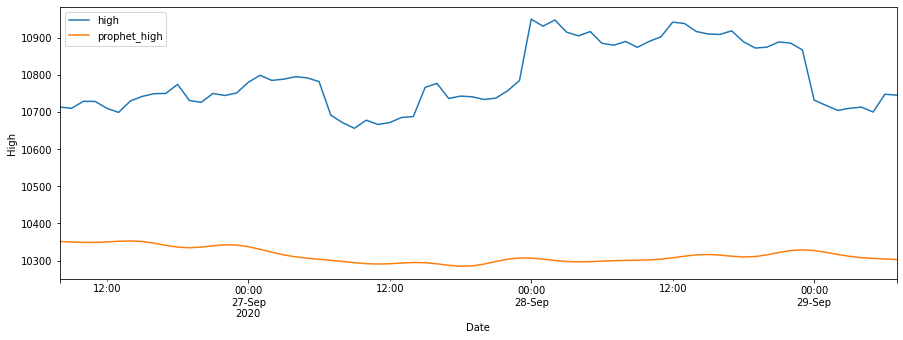

In [28]:
# ► Plot las 72 predictions and samples

ax = my_coin_forecast.set_index('date')[-72:].plot(figsize=(15, 5))
ax.set_ylabel('High')
ax.set_xlabel('Date')

plt.show()

## Arima

In [29]:
# ► Create a copy with values in reverse

my_coin_high_a = (my_coin[['Date','High']][:-72].copy()).set_index('Date')

In [30]:
my_coin_high_a.tail()

High
Date                         
2020-09-26 03:00:00  10746.66
2020-09-26 04:00:00  10737.11
2020-09-26 05:00:00  10820.94
2020-09-26 06:00:00  10766.00
2020-09-26 07:00:00  10739.35

In [31]:
# Arima tunning hyperparameters
# Initial approximation of parameters

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(my_coin_high_a.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [32]:
# ► Forecasting and renaming forecasting column

forecast_arima = pd.DataFrame(best_model.predict(start=0, end=len(my_coin_forecast)-1))
forecast_arima = forecast_arima.rename(columns = {0:'arima_high'})

In [52]:
forecast_arima

arima_high
0          0.000000
1      19509.718705
2        986.246830
3       3786.903498
4       4309.158348
...             ...
27335  10759.254587
27336  10763.419096
27337  10755.867191
27338  10755.785879
27339  10758.021530

[27340 rows x 1 columns]

In [39]:
len(my_coin_forecast)

27340

In [84]:
# ► Joining data frames

my_coin_forecast_cp = pd.concat([my_coin_forecast,forecast_arima], axis = 1, sort = True)
my_coin_forecast_cp = my_coin_forecast_cp.set_index('date')

In [87]:
# ► Comparing 72 unseen data by both models

my_coin_forecast_cp.tail()

high  prophet_high    arima_high
date                                                     
2020-09-29 03:00:00  10710.00  10311.481945  10759.254587
2020-09-29 04:00:00  10713.25  10308.000085  10763.419096
2020-09-29 05:00:00  10700.00  10305.873213  10755.867191
2020-09-29 06:00:00  10747.88  10304.399836  10755.785879
2020-09-29 07:00:00  10745.42  10302.825811  10758.021530

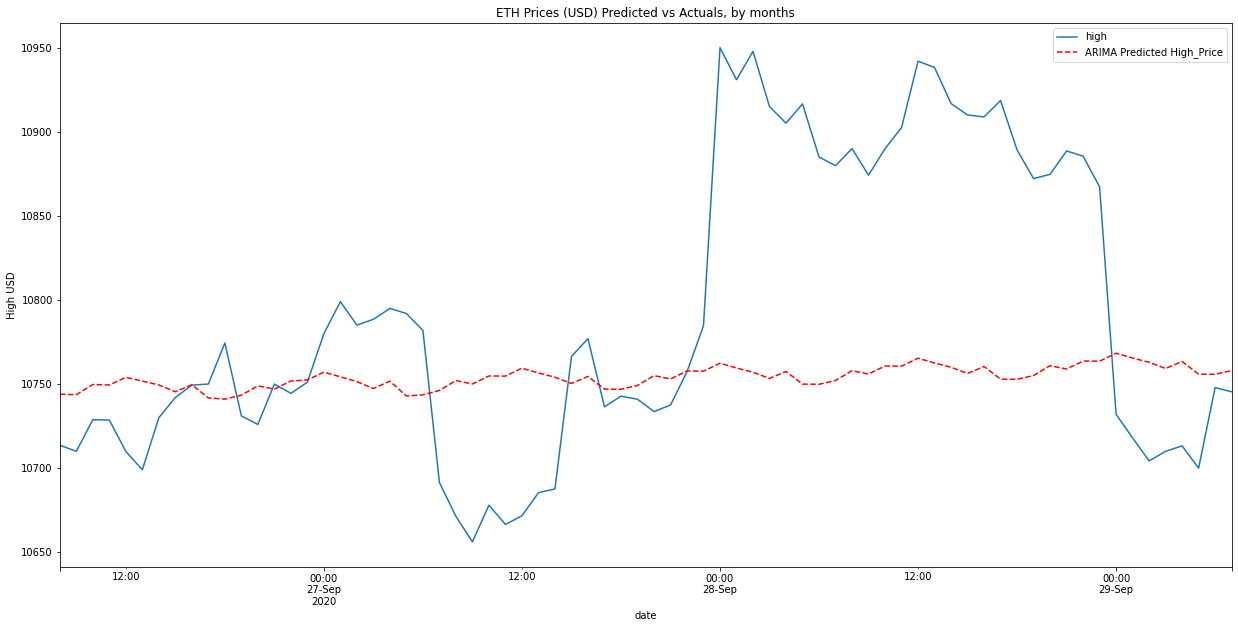

In [88]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-72:].plot()
my_coin_forecast_cp.arima_high[-72:].plot(color='r', ls='--', label='ARIMA Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

## XGBoost

In [89]:
# ► Function to bring more dates info to the xgboost model

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [90]:
# ► Creating data for training and testing 

X_train, y_train = create_features(my_coin_high_train, label='High')
X_test, y_test = create_features(my_coin_high_test, label='High')

In [97]:
# ► XGBoost model and hyperparameters (I recomend to change it for each coin)

model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.8, learning_rate = 0.4,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(alpha=10, colsample_bytree=0.8, learning_rate=0.4, max_depth=5,
             min_child_weight=10, objective='reg:squarederror')

In [98]:
# ► Forecasting values

xgb_preds = model.predict(X_test)

In [105]:
# ► Data frame with dates as index

xgb_preds_df = (pd.DataFrame({'Date':my_coin_high_test.Date.values, 'xgb_forec':xgb_preds})).set_index('Date')

In [106]:
# ► Joining to the rest of predictions 

my_coin_forecast_cp = pd.concat([my_coin_forecast_cp,xgb_preds_df], axis = 1, sort = False)

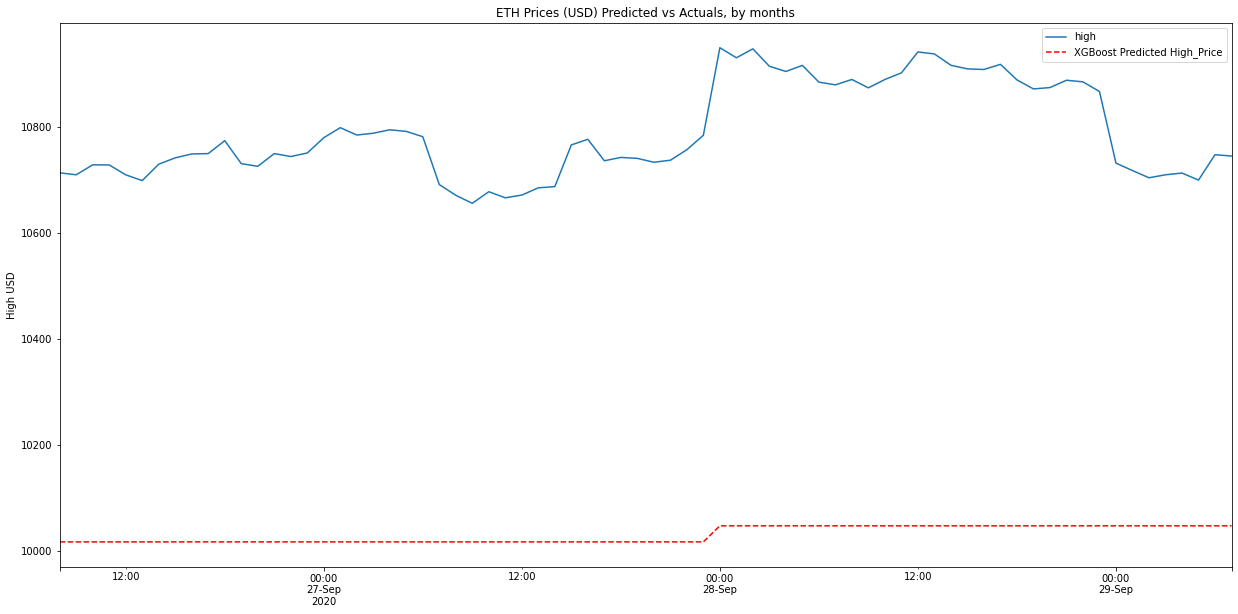

In [109]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-72:].plot()
my_coin_forecast_cp.xgb_forec[-72:].plot(color='r', ls='--', label='XGBoost Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

## PyCaret

In [110]:
# ► To use regression models

from pycaret.regression import *

In [111]:
# ► Taking same data to train the XGBoost but in the same df

my_coin_high_py = pd.concat([X_train, y_train], axis = 1, sort = False)

In [113]:
# ► Pycaret syntax, just press Enter

exp_reg = setup(data = my_coin_high_py, target = 'High')

 
Setup Succesfully Completed.


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:setup() succesfully completed......................................


In [114]:
best = compare_models()

INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7722, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [115]:
# ► Creating an ensemble meta-estimator that fits a base regressor on the whole dataset

blender_top3 = blend_models(compare_models(n_select = 3))

INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 7
INFO:logs:VotingRegressor(estimators=[('Extra Trees Regressor_0',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                            

In [116]:
# ► It does not plot Hyperparams cause is blended model  

evaluate_model(blender_top3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [117]:
# ► Stage of predictions taking only dates

lr_pred_new = predict_model(blender_top3, data = X_test)

In [118]:
my_coin_forecast_cp['pycaret_high'] = lr_pred_new['Label']
my_coin_forecast_cp['pycaret_high'][-72:] = lr_pred_new['Label']

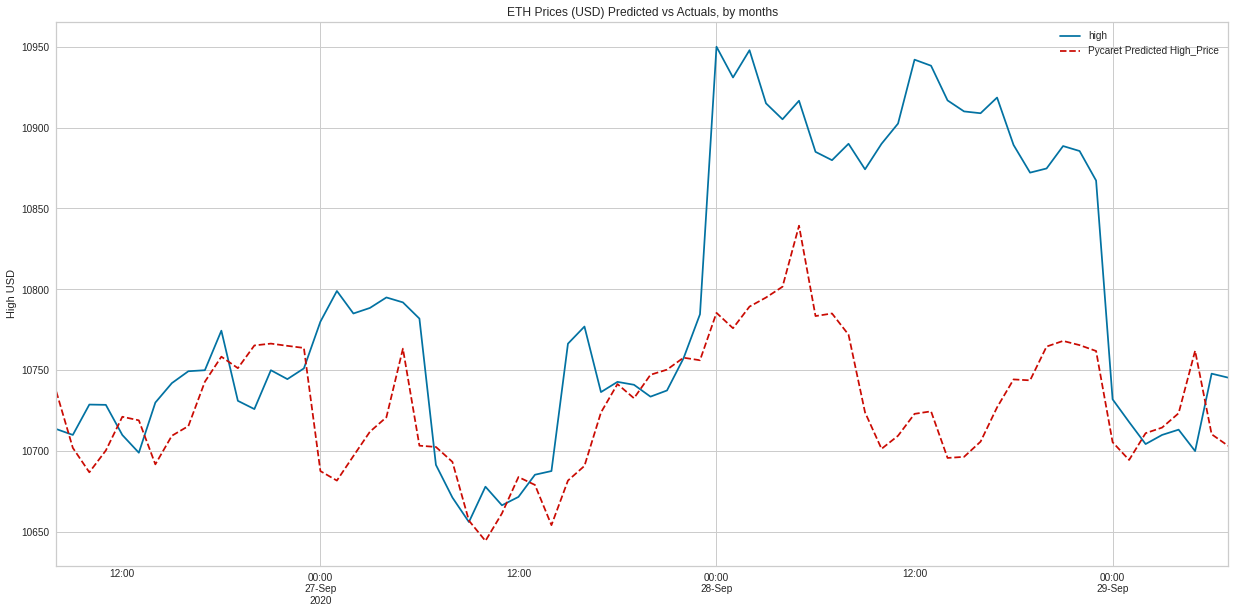

In [119]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-72:].plot()
my_coin_forecast_cp.pycaret_high[-72:].plot(color='r', ls='--', label='Pycaret Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

## LSTM (Long Short Term Memory)

In [120]:
# ► For more info: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py

# ► function inversed (to predict more data)

def predict_sequence_full(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    #return prediction_seqs
    return [scaler.inverse_transform(np.array(i).reshape(1, -1))[0].tolist() for i in prediction_seqs]

In [121]:
# ► Function to plot data windows

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [ ]:
# ► Loading Data and changing the order

#df = pd.read_csv('my_coin_daily_data.csv', index_col='Date', parse_dates = ['Date'])
#df = df[::-1]
#df.head()

In [126]:
dflstm = my_coin.set_index('Date')

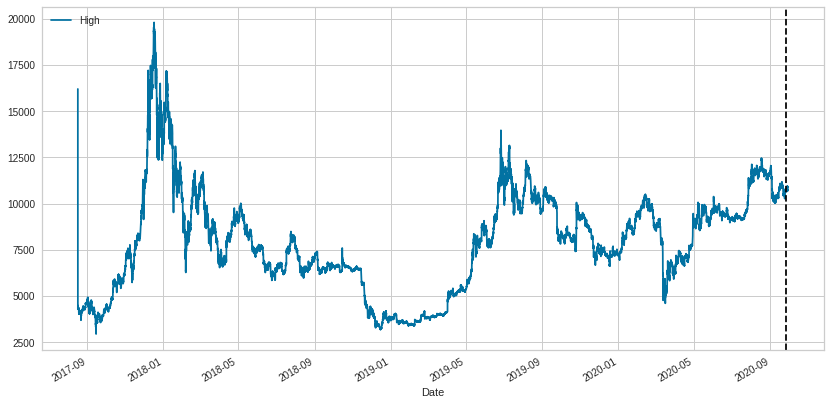

In [127]:
# ► Splitting data graph 72 samples to test

ax = dflstm.plot(figsize=(14, 7))
ax.axvline(dflstm.index[-72], linestyle="--", c="black")

In [128]:
# ► Scaling all data

scaler = MinMaxScaler(feature_range=(-1,1))
sc_lstm = scaler.fit_transform(dflstm.reset_index().drop(['Date'], 1))

In [129]:
def split_data(stock, lookback):
    
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = 72
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [131]:
lookback = 25 # choose sequence length
LSTM_train_inputs, LSTM_train_outputs, LSTM_test_inputs, LSTM_test_outputs = split_data(sc_lstm, lookback)
print('x_train.shape = ',LSTM_train_inputs.shape)
print('y_train.shape = ',LSTM_train_outputs.shape)
print('x_test.shape = ',LSTM_test_inputs.shape)
print('y_test.shape = ',LSTM_test_outputs.shape)

x_train.shape =  (27243, 24, 1)
y_train.shape =  (27243, 1)
x_test.shape =  (72, 24, 1)
y_test.shape =  (72, 1)


In [132]:
# ► LSTM model structure

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [133]:
# ► initialise model architecture
nn_model = build_model(LSTM_train_inputs, output_size=1, neurons = 32)

# ► train model on data
nn_history = nn_model.fit(LSTM_train_inputs, LSTM_train_outputs, 
                            epochs=14, batch_size=1, shuffle=True)

Epoch 1/14
27243/27243 [==============================] - 132s 5ms/step - loss: 0.0219
Epoch 2/14
27243/27243 [==============================] - 135s 5ms/step - loss: 0.0169
Epoch 3/14
27243/27243 [==============================] - 141s 5ms/step - loss: 0.0161
Epoch 4/14
27243/27243 [==============================] - 132s 5ms/step - loss: 0.0159
Epoch 5/14
27243/27243 [==============================] - 133s 5ms/step - loss: 0.0157
Epoch 6/14
27243/27243 [==============================] - 131s 5ms/step - loss: 0.0157
Epoch 7/14
27243/27243 [==============================] - 133s 5ms/step - loss: 0.0156
Epoch 8/14
27243/27243 [==============================] - 132s 5ms/step - loss: 0.0154
Epoch 9/14
27243/27243 [==============================] - 134s 5ms/step - loss: 0.0155
Epoch 10/14
27243/27243 [==============================] - 134s 5ms/step - loss: 0.0154
Epoch 11/14
27243/27243 [==============================] - 133s 5ms/step - loss: 0.0151
Epoch 12/14
27243/27243 [================

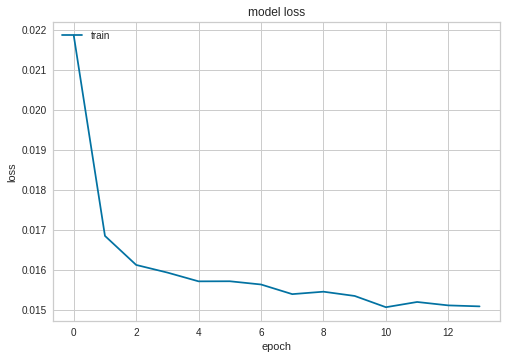

In [134]:
# ► Plot "Loss"
plt.plot(nn_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

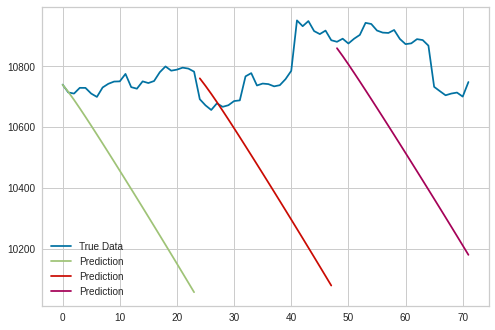

The Mean Absolute Error is: 341.02803168402784


In [146]:
# ► Calling functions to predict and plot windows

predsl = predict_sequence_full(nn_model, LSTM_test_inputs, 24, 24)
LSTM_test_outputs_inversed = scaler.inverse_transform(np.array(LSTM_test_outputs).reshape(1, -1))[0]
plot_results_multiple(predsl, LSTM_test_outputs_inversed, 24)
MAE = mean_absolute_error(LSTM_test_outputs_inversed, list(flatten(predsl)))
print('The Mean Absolute Error is: {}'.format(MAE))

In [136]:
# ► New column to the final data frame

my_coin_forecast_cp['LSTM_Forec'] = 'NaN'
my_coin_forecast_cp['LSTM_Forec'][-72:] = predsl[0]

## GRU (Gated Recurrent Units)

In [137]:
GRU_train_inputs = LSTM_train_inputs
GRU_train_outputs = LSTM_train_outputs
GRU_test_inputs = LSTM_test_inputs
GRU_test_outputs = LSTM_test_outputs

In [138]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=20, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=60, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=120, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=20, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(GRU_train_inputs, GRU_train_outputs,epochs=8,batch_size=72)

Epoch 1/8
379/379 [==============================] - 28s 73ms/step - loss: 0.0097
Epoch 2/8
379/379 [==============================] - 27s 71ms/step - loss: 0.0031
Epoch 3/8
379/379 [==============================] - 26s 69ms/step - loss: 0.0029
Epoch 4/8
379/379 [==============================] - 26s 68ms/step - loss: 0.0027
Epoch 5/8
379/379 [==============================] - 26s 69ms/step - loss: 0.0027
Epoch 6/8
379/379 [==============================] - 26s 69ms/step - loss: 0.0026
Epoch 7/8
379/379 [==============================] - 26s 69ms/step - loss: 0.0026
Epoch 8/8
379/379 [==============================] - 26s 69ms/step - loss: 0.0025


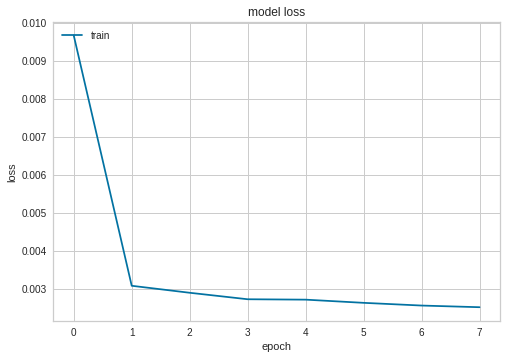

In [139]:
plt.plot(regressorGRU.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

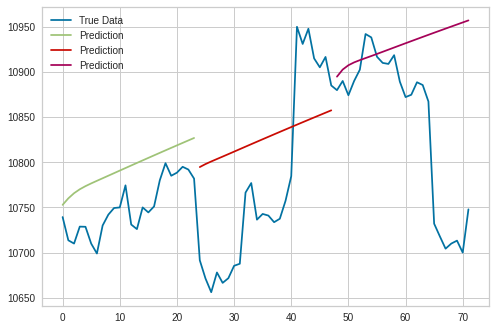

The Mean Absolute Error is: 75.14225640190966


In [147]:
# ► Calling functions to predict and plot windows

predsg = predict_sequence_full(regressorGRU, GRU_test_inputs, 24, 24)
GRU_test_inversed = scaler.inverse_transform(np.array(GRU_test_outputs).reshape(1, -1))[0]
plot_results_multiple(predsg, GRU_test_inversed, 24)
MAE = mean_absolute_error(GRU_test_inversed, list(flatten(predsg)))
print('The Mean Absolute Error is: {}'.format(MAE))

In [141]:
# ► New column to the final data frame

my_coin_forecast_cp['GRU_Forec'] = 'NaN'
my_coin_forecast_cp['GRU_Forec'][-72:] = predsg[0]

## Comparing

In [148]:
# ► Renaming columns

my_coin_forecast_cp.rename(columns={'high': 'High', 'prophet_high': 'Prophet_forec', 'arima_high': 'Arima_forec', 'xgb_forec': 'Xgboost_forec', 'pycaret_high': 'Pycaret_forec', 'LSTM_Forec': 'LSTM_forec', 'GRU_Forec': 'GRU_forec'}, inplace=True)

In [149]:
# ► The final data frame real price ('high') with all forecastings

my_coin_forecast_cp[-20:]

High  Prophet_forec  ...  LSTM_forec  GRU_forec
2020-09-28 12:00:00  10941.99   10307.556121  ...     9098.04    10901.8
2020-09-28 13:00:00  10938.25   10311.915387  ...     9063.08    10904.3
2020-09-28 14:00:00  10916.80   10315.430872  ...     9027.99    10906.7
2020-09-28 15:00:00  10910.00   10316.541281  ...     8992.78    10909.2
2020-09-28 16:00:00  10908.87   10314.884081  ...     8957.45    10911.6
2020-09-28 17:00:00  10918.57   10311.820444  ...        8922      10914
2020-09-28 18:00:00  10889.24   10309.809811  ...     8886.43    10916.4
2020-09-28 19:00:00  10872.15   10310.926133  ...     8850.74    10918.8
2020-09-28 20:00:00  10874.73   10315.493083  ...     8814.92    10921.2
2020-09-28 21:00:00  10888.59   10321.791545  ...     8778.99    10923.6
2020-09-28 22:00:00  10885.51   10327.044809  ...     8742.95    10925.9
2020-09-28 23:00:00  10867.25   10328.993825  ...     8706.78    10928.3
2020-09-29 00:00:00  10732.02   10327.023270  ...      8670.5    10930.6
2020-09-29 01:00:00  10717.98   10322.212906  ...     8634.11      10933
2020-09-29 02:00:00  10704.35   10316.476347  ...     8597.61    10935.3
2020-09-29 03:00:00  10710.00   10311.481945  ...     8560.99    10937.7
2020-09-29 04:00:00  10713.25   10308.000085  ...     8524.27      10940
2020-09-29 05:00:00  10700.00   10305.873213  ...     8487.44    10942.3
2020-09-29 06:00:00  10747.88   10304.399836  ...     8450.51    10944.6
2020-09-29 07:00:00  10745.42   10302.825811  ...     8413.47    10946.9

[20 rows x 7 columns]

In [152]:
import plotly.graph_objects as go
fig = go.Figure()

for i in my_coin_forecast_cp.columns:
    
    fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-20:], y=my_coin_forecast_cp[i][-20:],
                    mode='lines',
                    name=i))
    
fig.update_layout(title="Coin behavior (Ethereum) forecastings vs actuals, price in USD")

fig.show()

In [151]:
# ► In the last step to compare models, not before cause there are issues with sklearn versions for pmdarima and pycaret 

from sklearn.metrics import mean_squared_error as mse

print('Last 20 days mse Prophet: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.Prophet_forec[-20:]))
print('Last 20 days mse Arima: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.Arima_forec[-20:]))
print('Last 20 days mse Xgboost: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.Xgboost_forec[-20:]))
print('Last 20 days mse Pycaret: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.Pycaret_forec[-20:]))
print('Last 20 days mse LSTM: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.LSTM_forec[-20:]))
print('Last 20 days mse GRU: ',mse(my_coin_forecast_cp.High[-20:], my_coin_forecast_cp.GRU_forec[-20:]))

Last 20 days mse Prophet:  272898.454227395
Last 20 days mse Arima:  13135.487843448796
Last 20 days mse Xgboost:  619985.7893986122
Last 20 days mse Pycaret:  18202.34061011947
Last 20 days mse LSTM:  4302739.433217803
Last 20 days mse GRU:  19739.679990693443
